# About This Notebook

This notebook takes in data from https://www.reddit.com/r/winemaking/ via the Push Shift API found at www.pushshift.io

This notebook consists of five steps of initial data retrieval and preprocessing for a Natural Language Processing Project. 

The project at large will intake data from two different subreddits (from www.Reddit.com), clean and process the data, explore the data for relationships, create and manipulate features and then model to produce a predictive classification model. 

This notebook will begin the process described above through the following steps: 

Step 1: Data Retrieval - Is the process of pulling the data from Reddit using the Pushshift API.

Step 2: Initial Analysis for Cleaning - Which will analyze unique values, indexes and summary info. 

Step 3: Preprocessing / Cleaning - Will reduce the amount of features being processed, handle duplicate values, and eliminate null values. 

Step 4: Preliminary EDA - Will conduct an initial exploration of the data to analyze unique values in greater detail, initially explore the possibility of outliers in the data and look into features that may be interesting overall but that may not make it into the advanced EDA and modeling process. 

Step 5: Preparing DF for Text Analysis - This process will reduce feature columns to just those that will be used in advanced EDA and modeling. It will then save this file to CSV for the purpose of importing into another notebook focused on advanced EDA and feature creation. 

About r/winemaking subreddit:

* Created in November of 2008 it is a community for people interested in viticulture, winemaking and other fermented beverages. 
* At the time of this project there are around 39,000 members. 
* You can find more information about this community on their Reddit Wiki https://www.reddit.com/r/winemaking/wiki/index
* Here you will find information abou the moderators, links to winemaking tips and a list of places to source grapes. 

### Importing Libraries

In [1]:
import requests
import time
import pandas as pd
import numpy as np
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Step 1

# Data Retrieval

### Pulling in Data Using Pushift API

In [2]:
# defining url for pushshift apo
url = 'https://api.pushshift.io/reddit/submission/search'
# creating an empty list to collect the dataframe lists
dfs = []

# number of loops that will be made. Each loop pulls a new set of posts.
loops = 40

params = {
        'subreddit': 'winemaking', 
        'size': 100,
#         'before' :
        }


#defining the time in which I start the loop.
start_time = time.time()

#create for loop that sets the current time for the sake of ensuring we are not scraping too fast or taking too many of the sites reasoureces. 
for i in range(loops):
    
    current_time = time.time()
    #requesting data
    res = requests.get(url, params) #getting request
    print(f'res {i+1} code: ', res.status_code) #printing request status to ensure it went through securely
    
    data = res.json() #using json to read
    posts = data['data'] #indexing into 'data' from json dictionary and list of dictionaries
    posts_df = pd.DataFrame(posts)
    dfs.append(posts_df) #create dataframe from 'data' dictionary
        
        
    # get oldest post time and use as before parameter in next request
    params['before'] = posts_df['created_utc'].min()#adding 'before' parameter to params dictionary
        
    #created lower limit of 1 second to ensure we are abiding by resource conventions.
    time.sleep(3)

# creating a dataframe by concatetinating all of the df lists created by the loop    
reddit_posts = pd.concat(dfs)

res 1 code:  200
res 2 code:  200
res 3 code:  502


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [345]:
reddit_posts.shape

(4000, 83)

# Step 2
# Initial Analysis for Cleaning

### Initial Analysis of Unique Values (Prior to Cleaning)
* Note, I had to scrape 1,000 more values from the wine subbreddit than I did the homebrewing subreddit just to get close to the amount of unique posts. Oddly I cam up with more unique authors but less unique posts. 

#### 4000 unique post id's 

In [382]:
unique_ids = reddit_posts['id'].nunique()
unique_ids

4000

#### 2139 unique authors

In [383]:
unique_authors = reddit_posts['author'].nunique()
unique_authors

2140

#### 1943 unique posts

In [384]:
unique_posts = reddit_posts['selftext'].nunique()
unique_posts

1938

#### Percentage of Unique Posts to Unique IDs
* The percentage of unique posts in winemaking is much smaller than the percentage of unique posts in homebrewing. 

In [385]:
unique_posts / unique_ids

0.4845

________________________
## Column and Index Check

### Checking column index

In [386]:
reddit_posts.columns;

### Checking row index
* row index appears to be repeating similarly to how it was in the beer api_pull notebook. 
* It is due to the for-loop that I ran to pull from API. 
* going to reset index

In [387]:
reddit_posts.index

RangeIndex(start=0, stop=4000, step=1)

In [388]:
reddit_posts.reset_index(inplace = True, drop = True)

In [389]:
reddit_posts.index

RangeIndex(start=0, stop=4000, step=1)

______________________

### Summary Info

In [390]:
reddit_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 83 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  4000 non-null   object 
 1   allow_live_comments            4000 non-null   bool   
 2   author                         4000 non-null   object 
 3   author_flair_css_class         0 non-null      object 
 4   author_flair_richtext          3969 non-null   object 
 5   author_flair_text              0 non-null      object 
 6   author_flair_type              3969 non-null   object 
 7   author_fullname                3969 non-null   object 
 8   author_patreon_flair           3969 non-null   object 
 9   author_premium                 3713 non-null   object 
 10  awarders                       4000 non-null   object 
 11  can_mod_post                   4000 non-null   bool   
 12  contest_mode                   4000 non-null   b

# Step 3

# Preprocessing / Cleaning

## Create new Wine_1 dataframe with reduced columns

In [636]:
wine_1 = reddit_posts[['id', 'created_utc', 'title', 'selftext', 'author', 'score', 'num_comments', 'subreddit']]

In [637]:
wine_1.head()

,id,created_utc,title,selftext,author,score,num_comments,subreddit
0,kllhvo,1609138953,Resources for a newbie home winemaker,"I want to find a comprehensive resource (book,...",rooks-and-queens,1,4,winemaking
1,klhoel,1609124124,Marvel Marketing | #1 Growing Internet Marketi...,,PortiaPennr688,1,0,winemaking
2,klgc1s,1609119301,A question about kit wine,I’ve made quite a few batches that have all co...,drunkboater,1,7,winemaking
3,kldeal,1609109450,Riesling - My First Wine,"Hi Everyone,\n\nI am going to make some riesli...",ITSDSME,1,0,winemaking
4,kl86p7,1609092401,Carrot Wine Questions?,,mattstuff09,1,10,winemaking


### Checking for Duplicates
* There are none according to .duplicated()
* however, value_counts on 'selftext' reveal a few duplicated 'selftext' values.

In [638]:
wine_1.duplicated().value_counts()

False    4000
dtype: int64

There are a few removed and deleted values. Not as many as in the homebrewing data. 

In [639]:
wine_1['selftext'].value_counts().head()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 1942
[removed]                                                                         

### Eliminating 'removed' values

In [640]:
count = 0
for item in wine_1['selftext']:
    if item == '[removed]':
        count += 1
print(count)

76


In [641]:
wine_1 = wine_1[wine_1['selftext'] != '[removed]']

In [642]:
count = 0
for item in wine_1['selftext']:
    if item == '[removed]':
        count += 1
print(count)

0


### Eliminating 'deleted' values

In [643]:
count = 0
for item in wine_1['selftext']:
    if item == '[deleted]':
        count += 1
print(count)

30


In [644]:
wine_1 = wine_1[wine_1['selftext'] != '[deleted]']

In [645]:
count = 0 
for item in wine_1['selftext']:
    if item == '[deleted]':
        count += 1
print(count)

0


Resetting index again to account for dropped values

In [646]:
wine_1.reset_index(inplace = True, drop = True)

In [647]:
wine_1.index

RangeIndex(start=0, stop=3894, step=1)

In [648]:
wine_1.columns

Index(['id', 'created_utc', 'title', 'selftext', 'author', 'score',
       'num_comments', 'subreddit'],
      dtype='object')

### Eliminating duplicates
* Not as many as in the homebrewing data but a few exist. 

In [649]:
wine_1 = wine_1.drop_duplicates('selftext', keep = 'first').reset_index(drop = True)

In [650]:
wine_1.columns

Index(['id', 'created_utc', 'title', 'selftext', 'author', 'score',
       'num_comments', 'subreddit'],
      dtype='object')

Checking duplicates. No more exist

In [651]:
wine_1['selftext'].value_counts().nlargest();

In [652]:
wine_1.nunique()

id              1937
created_utc     1937
title           1912
selftext        1936
author          1267
score             22
num_comments      49
subreddit          1
dtype: int64

### Checking and Managing Null Values
* 1 null value in selftext. I will drop the row.  

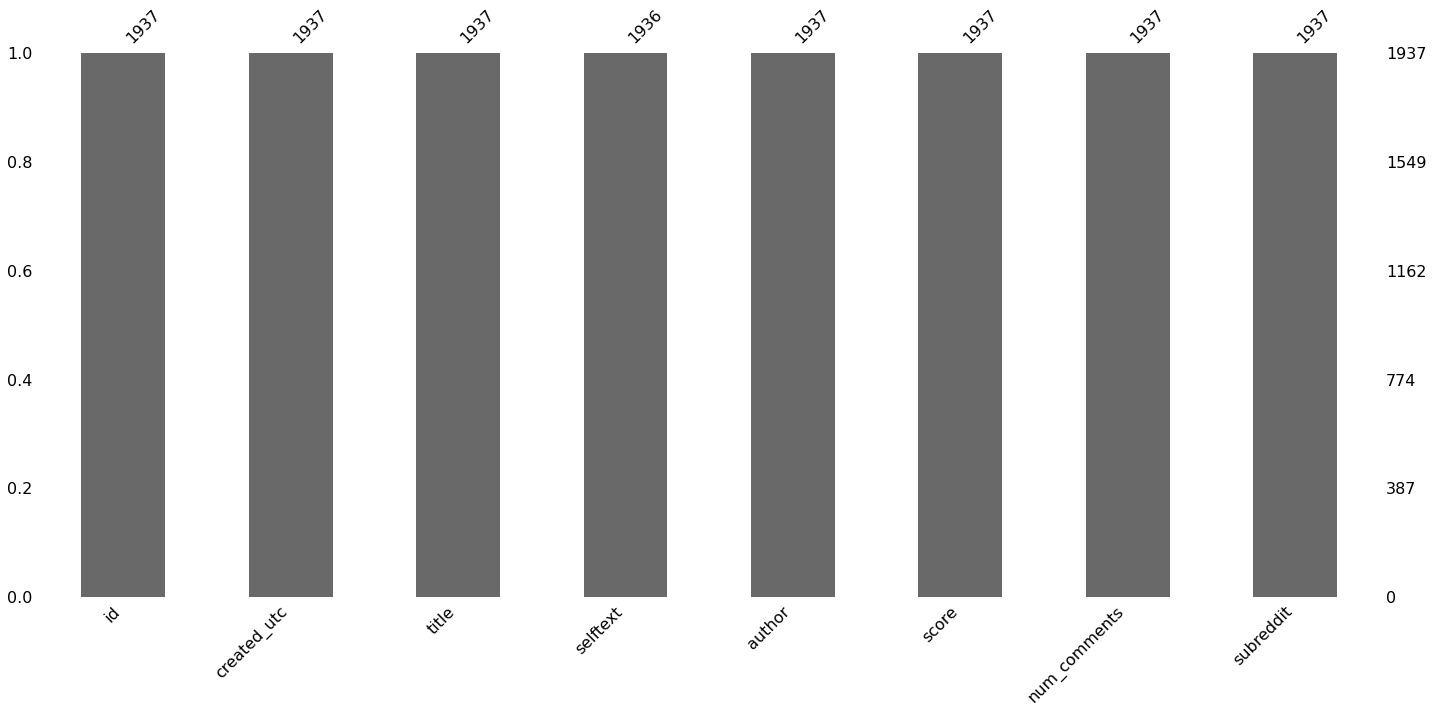

In [653]:
msno.bar(wine_1);

In [654]:
wine_1 = wine_1.dropna()

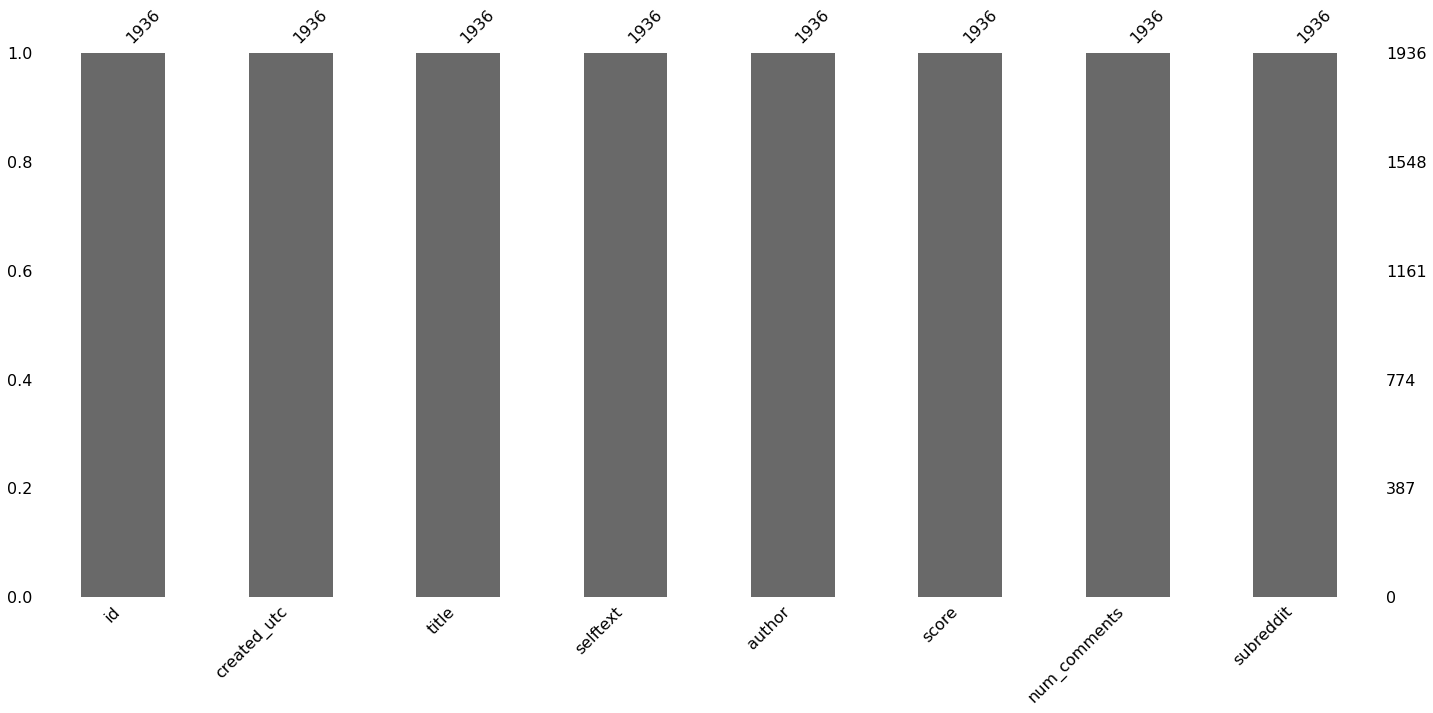

In [655]:
msno.bar(wine_1);

### Checking Post Lengths
To ensure there is content in every post

In [656]:
# There are no posts that have less than 5 characters
for post in wine_1['selftext']:
    if len(post) < 5:
        print(post)

Creating a list of post lengths to add to a histogram

In [657]:
post_lengths = []
for post in wine_1['selftext']:
    post_lengths.append(len(post))
len(post_lengths) # ensuring I got all the values. 

1936

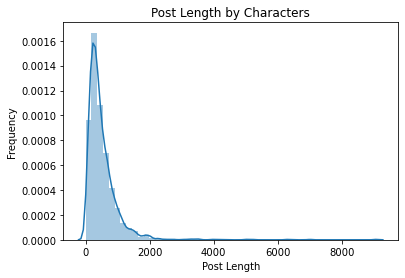

In [658]:
sns.distplot(post_lengths).set_title('Post Length by Characters')

plt.xlabel('Post Length')
plt.ylabel('Frequency');

# Step 4
# Preliminary EDA
* This Exploratory Data Analysis is being conducted for the purpose of getting to know the data that surrounds the target data and predictor variables. It is also being utulized to identify any useful and interesting statistics or relationships that exist outside of predictive modeling and the exploratory process that preceeds modeling. 

### Unique Author / Unique Post Analysis

Unique Authors

In [659]:
unique_authors = wine_1['author'].nunique()
unique_authors

1266

Unique Posts

In [660]:
unique_posts = wine_1['selftext'].nunique()
unique_posts

1936

Authors of Multiple Posts
* There are 313 repeat authors of 1264 unique authors. 
* Almost 33% percent of authors are multiple posters. 


In [661]:
author_multi = wine_1['author'].value_counts() > 1

In [662]:
author_multi.value_counts()

False    954
True     312
Name: author, dtype: int64

In [663]:
313 / 951

0.3291272344900105

In [664]:
total_multi_posts = wine_1['author'].value_counts().nlargest(313).sum()
total_multi_posts

983

In [665]:
total_multi_posts / unique_posts

0.5077479338842975

_________________________________________________

#### Analyzing Posts with Multiple Comments

In [666]:
multi_comment_count = wine_1['num_comments'][wine_1['num_comments'] > 1].count()
multi_comment_count

1614

#### Boxplot for Number of Comments (Prior to Eliminating Outliers if Necessary)

Box plot showing distribution of the comment counts within and outside of the interquartile range. 

The whisker for the quartile is the vertical grey line. It is the 75 percentile plus 1.5 times the interquartile range. The black dots past that whisker are considered outliers. There a few outliers here but the variance and number is much smaller than what existed in the Homebrew data. Further data cleaning may not be needed. 

That being said, in alignment with the Homebrew data, the vast majority of posts receiving multiple comments are located closer to zero. The entire IQR is located below 10.  

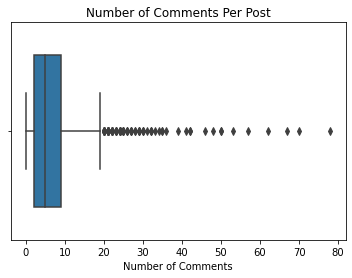

In [667]:
sns.boxplot(wine_1['num_comments'], width = .7, whis = 1.5).set_title('Number of Comments Per Post')

plt.xlabel('Number of Comments');

83 percent of posts had more than 1 comment. 
* This is slightly more discerning than homebrewing subreddit which had 94%. 

In [668]:
multi_comment_count / unique_posts

0.8336776859504132

In [669]:
wine_1.describe()

,created_utc,score,num_comments
count,1.936000e+03,1936.000000,1936.000000
mean,1.592434e+09,1.346591,6.566632
std,1.001876e+07,2.198947,7.023453
min,1.571503e+09,0.000000,0.000000
25%,1.585082e+09,1.000000,2.000000
50%,1.593501e+09,1.000000,5.000000
75%,1.600580e+09,1.000000,9.000000
max,1.609139e+09,52.000000,78.000000


If a post received less than 2 comments it was in the bottom 25% in terms of number of comments. The Homebrew data had a larger threshold for Q1 at 5 comments. If you received over 9 comments you were in the highest 25% of comment receivers. Again, this is lower than threshold the Homebrew data which saw a Q3 threshold of 16. 

### Analyzing Five Largest Comment Achievers

In [670]:
wine_1['num_comments'].nlargest()

217     78
183     70
1279    67
1684    62
1872    57
Name: num_comments, dtype: int64

Checking to see if anything odd exists in top give comment values. 

In [671]:
wine_1.loc[[215, 181, 1277, 1682, 1870], 'selftext']

215     I'm bottling and sealing a small run of bottle...
181     Hey all\n\nI'm doing a little research on what...
1277    Hello, so I am planning to age my mead in a sa...
1682                                I sound greedy i know
1870    Hi everyone,\n\nI hope someone here can advise...
Name: selftext, dtype: object

Nothing seems unusal. I will leave comments the way they are. 

### Analyzing Score

In [672]:
wine_1['score'].nlargest()

1368    52
865     46
907     21
1375    20
1721    19
Name: score, dtype: int64

Posts that score over 1 (the base score) account for nearly 9 percent of posts. A fairly small fraction of posts actually get scored. This is inline with the Homebrew data which received a score in about 7 percent of posts. 

In [673]:
score_over_1_count = wine_1['score'][wine_1['score'] > 1].count()
score_over_1_count

168

None of the top five scores (below) seem out of the ordinary. 

In [674]:
wine_1.loc[[1366, 863, 905, 1373, 1719], 'selftext']

1366    Today I noticed there was retentate (the dirty...
863     My skeeter pee has been actively bubbling for ...
905     [The Grapes(last pics are the best)](https://i...
1373    Does anyone have any advice for progressing ho...
1719    Tl;dr my extremely frugal friend drank lees fr...
Name: selftext, dtype: object

In [675]:
score_over_1_count / unique_posts

0.08677685950413223

# Step 5
# Preparing DF for Text Analysis

In [676]:
wine_1.columns

Index(['id', 'created_utc', 'title', 'selftext', 'author', 'score',
       'num_comments', 'subreddit'],
      dtype='object')

In [677]:
wine_1 = wine_1.drop(columns = ['id', 'created_utc', 'author', 'score', 'num_comments'])

In [678]:
wine_1.columns

Index(['title', 'selftext', 'subreddit'], dtype='object')

### Adding title to self text for the purpose of text analysis

In [679]:
wine_1['selftext'] = wine_1['title'] + ' ' + wine_1['selftext']

In [680]:
wine_1['selftext'].head()

0    Resources for a newbie home winemaker I want t...
1    Marvel Marketing | #1 Growing Internet Marketi...
2    A question about kit wine I’ve made quite a fe...
3    Riesling - My First Wine Hi Everyone,\n\nI am ...
4    Persimmon Wine Straining? Hello! This is my fi...
Name: selftext, dtype: object

In [681]:
wine_1

,title,selftext,subreddit
0,Resources for a newbie home winemaker,Resources for a newbie home winemaker I want t...,winemaking
1,Marvel Marketing | #1 Growing Internet Marketi...,Marvel Marketing | #1 Growing Internet Marketi...,winemaking
2,A question about kit wine,A question about kit wine I’ve made quite a fe...,winemaking
3,Riesling - My First Wine,"Riesling - My First Wine Hi Everyone,\n\nI am ...",winemaking
4,Persimmon Wine Straining?,Persimmon Wine Straining? Hello! This is my fi...,winemaking
...,...,...,...
1932,Pistachio Wine,Pistachio Wine [Pistachio Wine](https://imgur....,winemaking
1933,New Labels,New Labels Made new labels ready for bottling ...,winemaking
1934,Must pump,Must pump I know this is a shot in the dark bu...,winemaking
1935,Graphic designer for the wine industry,Graphic designer for the wine industry Hello d...,winemaking


In [682]:
# found a marketing add above that I didn't find previously. I am going to remove it. 
wine_1.drop(1, inplace = True)

In [684]:
wine_1.reset_index(inplace = True, drop = True)

In [685]:
wine_1

,title,selftext,subreddit
0,Resources for a newbie home winemaker,Resources for a newbie home winemaker I want t...,winemaking
1,A question about kit wine,A question about kit wine I’ve made quite a fe...,winemaking
2,Riesling - My First Wine,"Riesling - My First Wine Hi Everyone,\n\nI am ...",winemaking
3,Persimmon Wine Straining?,Persimmon Wine Straining? Hello! This is my fi...,winemaking
4,Wire used for Trellis,Wire used for Trellis Hey all - I'm planting s...,winemaking
...,...,...,...
1930,Pistachio Wine,Pistachio Wine [Pistachio Wine](https://imgur....,winemaking
1931,New Labels,New Labels Made new labels ready for bottling ...,winemaking
1932,Must pump,Must pump I know this is a shot in the dark bu...,winemaking
1933,Graphic designer for the wine industry,Graphic designer for the wine industry Hello d...,winemaking


# Saving new df to CSV

In [686]:
wine_1.to_csv('../data/wine.csv', index = False)